In [1]:
import bilby as bb
import gwpopulation as gwpop
import jax
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
import os
import bilby

In [2]:
gwpop.set_backend("jax")

xp = gwpop.utils.xp


# In[2]:


project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'


# ## Load posteriors

# In[3]:


posteriors = pd.read_pickle(os.path.join(project_dir, 'gwpopulation', 'BBH', 'redshift_posteriors_499_events.pkl'))


# ## Load injections

# In[4]:


import dill

with open(os.path.join(project_dir, 'gwpopulation', 'BBH', 'detected_injections.pkl'), "rb") as ff:
    injections = dill.load(ff)


# ## Define models and likelihood

# In[5]:


model = NonCachingModel(
    model_functions=[gwpop.models.redshift.MadauDickinsonRedshift(cosmo_model="Planck18", z_max=8)],
    #model_functions=[gwpop.models.redshift.PowerLawRedshift(z_max=8)],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
)

In [8]:
outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'run01_opt_SNR_injections')

In [9]:
result = bilby.result.read_in_result(filename=os.path.join(outdir, 'Asharp-study-gwpop_result.hdf5'))

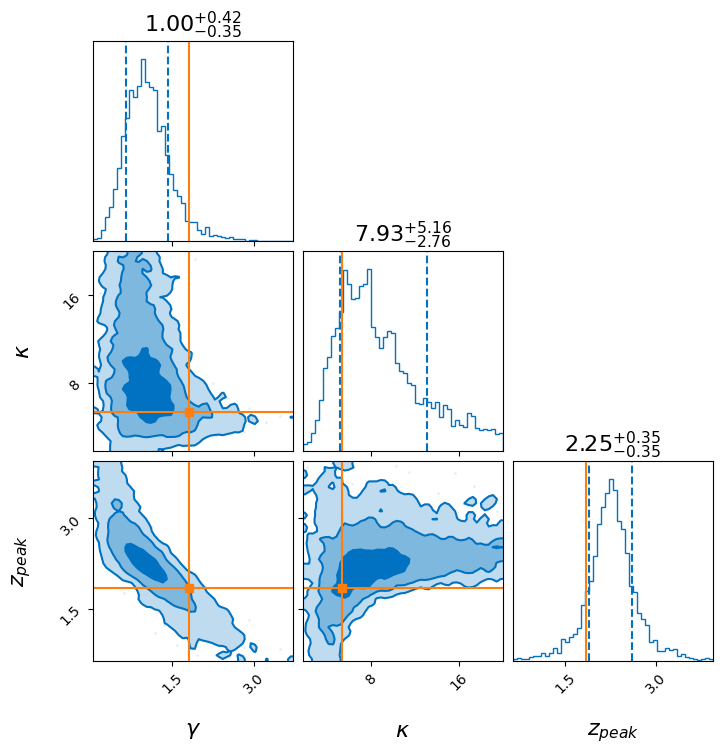

In [10]:
result.plot_corner(parameters={'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}, outdir=outdir)

In [10]:
likelihood.ln_likelihood_and_variance()

KeyError: 'gamma'

In [15]:
#func = jax.jit(likelihood.generate_extra_statistics)
func = jax.jit(likelihood.ln_likelihood_and_variance)

In [11]:
result.posterior.to_dict(orient='records')[0]

{'gamma': 0.5660044650342461,
 'kappa': 13.770593778003917,
 'log_likelihood': 4517.6299984969955,
 'log_prior': -5.857933154483459,
 'z_peak': 1.9944077462933847}

In [18]:
likelihood.ln_likelihood_and_variance?

Signature: likelihood.ln_likelihood_and_variance()
Docstring: Compute the ln likelihood estimator and its variance.
File:      ~/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/gwpopulation/hyperpe.py
Type:      method

In [16]:
func(result.posterior.to_dict(orient='records')[0])

TypeError: HyperparameterLikelihood.ln_likelihood_and_variance() takes 1 positional argument but 2 were given

In [ ]:
full_posterior = pd.DataFrame(
    [func(parameters) for parameters in result.posterior.to_dict(orient="records")]
).astype(float)
full_posterior.describe()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c41fe62d190>>
Traceback (most recent call last):
  File "/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c41fe62d190>>
Traceback (most recent call last):
  File "/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c41fe62d190>>
Traceback (most recent call last):
  File "/home/divyajyoti/miniconda3/envs/gwpopulation/lib